<a href="https://colab.research.google.com/github/kahram-y/AML_project/blob/main/AML(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1) 데이터 로딩 및 기초 탐색(EDA)**

In [1]:
import pandas as pd

# 1. 데이터 로드
from google.colab import drive
drive.mount('/content/drive')

# 파일 경로
trans_path = '/content/drive/MyDrive/HI-Medium_Trans.csv'
accounts_path = '/content/drive/MyDrive/HI-Medium_accounts.csv'

# pandas 옵션 (컬럼 전체 표시)
pd.set_option('display.max_columns', None)

# CSV 로드
trans = pd.read_csv(trans_path)
accounts = pd.read_csv(accounts_path)

# 실습을 위해 데이터 샘플링 (전체 데이터가 매우 큼)
trans = trans.head(50000)

print(trans.head(), trans.describe())
print(accounts.head(), accounts.describe())

# Label 분포 확인
print(trans['Is Laundering'].value_counts(normalize=True))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
          Timestamp  From Bank    Account  To Bank  Account.1  \
0  2022/09/01 00:17         20  800104D70       20  800104D70   
1  2022/09/01 00:02       3196  800107150     3196  800107150   
2  2022/09/01 00:17       1208  80010E430     1208  80010E430   
3  2022/09/01 00:03       1208  80010E650       20  80010E6F0   
4  2022/09/01 00:02       1208  80010E650       20  80010EA30   

   Amount Received Receiving Currency  Amount Paid Payment Currency  \
0          6794.63          US Dollar      6794.63        US Dollar   
1          7739.29          US Dollar      7739.29        US Dollar   
2          1880.23          US Dollar      1880.23        US Dollar   
3      73966883.00          US Dollar  73966883.00        US Dollar   
4      45868454.00          US Dollar  45868454.00        US Dollar   

  Payment Format  Is Laundering  
0   Reinvestment   

<Axes: xlabel='hour'>

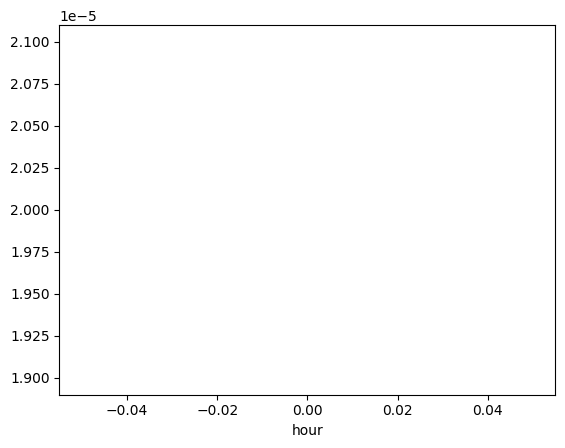

In [2]:
# 시간 분포
trans['Datetime'] = pd.to_datetime(trans['Timestamp'])
trans['hour'] = trans['Datetime'].dt.hour
trans.groupby('hour')['Is Laundering'].mean().plot()

-> 시간 단위 분포 확인.

**2) 계좌 레벨 노드 라벨링 구성**

In [3]:
# 거래 기준 계좌 노드 생성
# from/to 계좌의 laundering 여부를 동시에 취합해서 계좌 노드 단위 라벨링 수행
accounts_laundering = set(trans.loc[trans['Is Laundering']==1, 'Account']).union(
    set(trans.loc[trans['Is Laundering']==1, 'Account.1'])
)

accounts['label'] = accounts['Account Number'].apply(lambda x: 1 if x in accounts_laundering else 0)
accounts['label'].value_counts(normalize=True)

,proportion
label,
0,9.999990e-01
1,9.579526e-07


- 라벨 불균형 확인.

- Node Classification 문제 정의 완료 -> 이후 시간 단위 배치 모델 설계 근거 확보.

**3) Feature Engineering**

In [12]:
# Datetime 컬럼이 시계열 타입인지 확인
trans['Datetime'] = pd.to_datetime(trans['Datetime'])

# Account별로 시간을 오름차순 정렬
trans = trans.sort_values(by=['Account', 'Datetime']).reset_index(drop=True)

# 'Direction' 컬럼이 없는 경우 생성하는 로직
import numpy as np
if 'Direction' not in trans.columns:
    # Account 컬럼이 From_Account와 같다면 OUT, 아니면 IN (데이터 구조에 맞게 수정 필요)
    trans['Direction'] = np.where(trans['Account'] == trans['Account'], 'OUT', 'IN')

# 3-1. 기본 시간 집계 Feature (거래량/금액)     ➡️ 윈도우당 6개 × 4 = 24개
WINDOWS = ['1H', '3H', '6H', '24H']

features = []
for w in WINDOWS:
    f = trans.groupby('Account').rolling(w, on='Datetime')['Amount Paid'].agg([
        'count', 'sum', 'mean', 'std', 'max', 'min'
    ]).reset_index()
    f.columns = [f"{c}_{w}" if c!='Account' else c for c in f.columns]
    features.append(f)

# 3-2. 입금/출금 분리 Feature     ➡️ 4개 추가 (총 28)
for direction in ['IN','OUT']:
    df = trans[trans['Direction']==direction].copy()
    if not df.empty:
        # Amount Paid가 확실히 숫자여야 합니다.
        df['Amount Paid'] = pd.to_numeric(df['Amount Paid'], errors='coerce').fillna(0)

        agg = df.groupby('Account').rolling('24H', on='Datetime')['Amount Paid'].agg([
            'count', 'sum'
        ]).reset_index()
        agg.columns = ['Account','Datetime', f'{direction}_cnt_24H', f'{direction}_sum_24H']

# 3-3. 외화 / 통화 Feature    ➡️ 2개 추가 (총 30)
fx = trans[trans['Payment Currency']!='USD']
fx_feat = fx.groupby('Account').rolling('24H', on='Datetime')['Amount Paid'].agg([
        'count', 'sum'
    ]).reset_index()

# 3-4 상대방 다양성 / 네트워크 행동 Feature   ➡️ 2개 추가 (총 32)
def get_entropy(x):
    if len(x) <= 1: return 0
    probs = x.value_counts(normalize=True)
    return -(probs * np.log(probs + 1e-9)).sum() # 0 방지용 epsilon 추가

# 컬럼을 미리 선택하지 말고, rolling 후 apply 안에서 로직을 수행합니다.
counter_nunique = trans.groupby('Account').rolling('24H', on='Datetime')['Account.1'].apply(lambda x: len(np.unique(x)), raw=False).reset_index()
counter_entropy = trans.groupby('Account').rolling('24H', on='Datetime')['Account.1'].apply(get_entropy, raw=False).reset_index()

# 두 결과를 합칩니다.
counter = counter_nunique.copy()
counter.columns = ['Account', 'Datetime', 'uniq_counter_24H']
counter['entropy_24H'] = counter_entropy['Account.1']

# 3-5 반복 패턴 / Burst Feature   ➡️ 2개 추가 (총 34)
trans['time_diff'] = trans.groupby('Account')['Datetime'].diff().dt.total_seconds()

# [중요] 결측치를 0으로 채우고 수치형(float)으로 강제 변환
trans['time_diff'] = trans['time_diff'].fillna(0).astype(float)

# 이제 rolling 연산을 수행합니다.
burst = trans.groupby('Account').rolling('24H', on='Datetime')['time_diff'].agg([
    'min', 'mean'
]).reset_index()

# 컬럼명 정리
burst.columns = ['Account', 'Datetime', 'min_gap_24H', 'mean_gap_24H']

# 3-6 Graph 기반 집계 Feature    ➡️ 3개 추가 (총 37)
import networkx as nx
G = nx.from_pandas_edgelist(trans, 'Account','Account.1', create_using=nx.DiGraph())

accounts['deg'] = accounts['Account Number'].map(nx.degree_centrality(G))
accounts['bet'] = accounts['Account Number'].map(nx.betweenness_centrality(G, k=2000))
accounts['pr'] = accounts['Account Number'].map(nx.pagerank(G))

# 3-7 Time-aware Graph Feature    ➡️ 1개 추가 (총 38)
# 최근 24H 서브그래프
recent = trans[trans['Datetime']>=cutoff_time]
G24 = nx.from_pandas_edgelist(recent, 'Account','Account.1', create_using=nx.DiGraph())
accounts['deg_24h'] = accounts['Account Number'].map(nx.degree_centrality(G24))

# 3-8 금융결제원 관점 국가 / 채널 위험 Feature
# 3-8(1) 국가 위험 점수 매핑    ➡️ 2개 추가 (총 40)
country_risk = {
    'IR':0.9, 'RU':0.8, 'CN':0.7, 'US':0.2, 'KR':0.1
}
trans['country_risk'] = trans['Account.1 Country'].map(country_risk).fillna(0.3)

risk_feat = trans.groupby('Account').rolling('24H', on='Datetime')['country_risk'].agg([
    'sum', 'mean'
]).reset_index()
risk_feat.columns = ['Account', 'Datetime', 'risk_sum_24H', 'risk_mean_24H']

# 3-8(2) 채널 위험 Feature (핀테크 / ATM / Crypto)      ➡️ 2개 추가 (총 42)
channel_risk = {'CRYPTO':0.9,'ATM':0.7,'MOBILE':0.3,'BRANCH':0.1}
trans['channel_risk'] = trans['Channel'].map(channel_risk).fillna(0.2)

channel_feat = trans.groupby('Account').rolling('24H', on='Datetime')['channel_risk'].agg([
    'sum', 'max'
]).reset_index()
channel_feat.columns = ['Account', 'Datetime', 'ch_risk_sum_24H', 'ch_risk_max_24H']

/tmp/ipython-input-18055763.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  f = trans.groupby('Account').rolling(w, on='Datetime')['Amount Paid'].agg([
/tmp/ipython-input-18055763.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  f = trans.groupby('Account').rolling(w, on='Datetime')['Amount Paid'].agg([
/tmp/ipython-input-18055763.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  f = trans.groupby('Account').rolling(w, on='Datetime')['Amount Paid'].agg([
/tmp/ipython-input-18055763.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  f = trans.groupby('Account').rolling(w, on='Datetime')['Amount Paid'].agg([
/tmp/ipython-input-18055763.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  f = trans.groupby('Ac

DataError: No numeric types to aggregate

**4) Baseline ML – Boosting**


전통 부스팅 모델 (XGBoost/LightGBM/CatBoost)

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit

X = feature_df.drop(columns=['label'])
y = feature_df['label']

model = XGBClassifier(
n_estimators=300,
max_depth=6,
learning_rate=0.05,
scale_pos_weight= (y==0).sum()/(y==1).sum()
)

model.fit(X, y)

XAI (SHAP)

In [ ]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

**5. Graph Feature Engineering**

In [ ]:
import networkx as nx

G = nx.from_pandas_edgelist(
trans,
source='From Account',
target='To Account',
edge_attr='Amount Paid',
create_using=nx.DiGraph()
)

centrality = nx.degree_centrality(G)
betweenness = nx.betweenness_centrality(G, k=1000)

accounts['degree_centrality'] = accounts['Account'].map(centrality)
accounts['betweenness'] = accounts['Account'].map(betweenness)

-> Baseline Feature + Graph Feature 기여도 비교.

**6) GNN + Node Classification**

In [ ]:
# PyG 기반 node classification pipeline (예시)
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
def __init__(self, in_dim, hid_dim):
super().__init__()
self.conv1 = GCNConv(in_dim, hid_dim)
self.conv2 = GCNConv(hid_dim, 2)

def forward(self, x, edge_index):
x = self.conv1(x, edge_index).relu()
return self.conv2(x, edge_index)

model = GCN(in_dim=X.shape[1], hid_dim=64)

-> 전통 ML vs GNN 성능 비교 분석.

**7. 평가 & Backtest**

Top-K 평가

In [ ]:
K = 500
pred = model.predict_proba(X_test)[:,1]
topk_idx = pred.argsort()[-K:]

precision = y_test.iloc[topk_idx].mean()

Score Band 분석 (0–1000)

In [ ]:
score = (pred * 1000).astype(int)
bins = pd.cut(score, bins=10)

pd.crosstab(bins, y_test)

**8. Temporal GNN (TGN) 확장 구조**

왜 TGN인가?

- AML 패턴은 "언제 연결됐는지" 가 핵심

- Static GNN → 시간 정보 손실

- TGN → 시간 인코딩 + 메모리

PyG Temporal Data 구성

In [ ]:
from torch_geometric.data import TemporalData


data = TemporalData(
src=torch.tensor(trans['From Account'].values),
dst=torch.tensor(trans['To Account'].values),
t=torch.tensor(trans['ts'].values),
msg=torch.tensor(trans[feat_cols].values)
)

TGN 모델 Skeleton

In [ ]:
from torch_geometric.nn.models import TGN

model = TGN(
num_nodes=num_nodes,
raw_msg_dim=len(feat_cols),
memory_dim=100,
time_dim=50,
embedding_dim=100
)